In [1]:
import warnings
warnings.filterwarnings("ignore")
import requests 
from urllib.parse import urlencode 

import pandas as pd
import numpy as np
import seaborn as sns
import scipy
from scipy import stats
import plotly.express as px
import matplotlib.pyplot as plt
import pandahouse as ph

sns.set(
    font_scale =1.5,
    style      ='darkgrid',
    rc         ={'figure.figsize':(9,5)})

## Задание 1. A/B–тестирование

1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

    groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
    groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
    active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
    checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

    На какие метрики Вы смотрите в ходе анализа и почему?
    Имеются ли различия в показателях и с чем они могут быть связаны?
    Являются ли эти различия статистически значимыми?
    Стоит ли запускать новую механику на всех пользователей?

Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

1.4 Требования к ответу

    При выполнении тестового задания необходимо использовать язык программирования Python. 
    В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
    Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

Приступим.
Первым делом подгрузим имеющиемся данные, посмотрим описательные характеристики, проведем предобработку, проверим, присутствуют ли пропущенные значения в данных, поменяем типы данных, если это необходимо.

In [2]:
groups = pd.read_csv(r'Проект_2_groups.csv', sep = ';')
group_add = pd.read_csv(r'Проект_2_group_add.csv', sep = ',')
active_studs = pd.read_csv(r'Проект_2_active_studs.csv', sep = ';')
checks = pd.read_csv(r'Проект_2_checks.csv', sep = ';')

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups = groups.rename(columns = {'id': 'student_id'})

In [5]:
display(groups.shape, \
        groups.duplicated().sum(), \
        groups.isna().sum())

(74484, 2)

0

student_id    0
grp           0
dtype: int64

 Пропущенных значений и дубликатов в таблице groups нет.
 \
 Посмотрим на количество пользователей в каждой группе.

In [6]:
groups.groupby('grp', as_index = False).count()

,grp,student_id
0,A,14671
1,B,59813


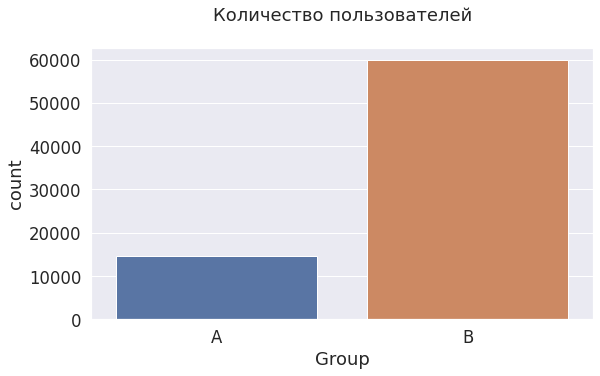

In [7]:
ax = sns.countplot(x = groups['grp'].sort_values())
ax.set_title('Количество пользователей\n')
ax.set_xlabel('Group');

В контрольной группе (А) 14671 чел, в тестовой (B) – 59813 чел.  
\
Как правило, выборка тестовой группы меньше контрольной. Полученное же распределение по группам выглядит довольно странно.

In [8]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [9]:
display(active_studs.shape, \
        active_studs.duplicated().sum(), \
        active_studs.isna().sum())

(8341, 1)

0

student_id    0
dtype: int64

 Пропущенных значений и дубликатов в таблице active_studs нет.
 \
 На платформу в дни проведения эксперимента заходило 8341 человек. Проверим всем ли была присвоена группа А или В:

In [10]:
active_studs.student_id.isin(groups.student_id).value_counts()

True     8328
False      13
Name: student_id, dtype: int64

13 активных пользователей без указания группы. Их в дальнейшем учитывать не будем.

In [11]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [12]:
display(checks.shape, \
        checks.student_id.duplicated().sum(), \
        checks.isna().sum())

(541, 2)

0

student_id    0
rev           0
dtype: int64

 Пропущенных значений и дубликатов нет. Всего 541 оплата, каждый пользователь совершил одну покупку, повторных покупок нет.
 \
 Проверим все ли пользователи, совершившие оплату заходили на платформу в дни эксперимента.

In [13]:
checks.student_id.isin(active_studs.student_id).value_counts()

True     392
False    149
Name: student_id, dtype: int64

Получается, что 149 пользователей совершили оплату, не заходя на платформу. Возможно это подключены автоплатежи, произошло автоматическое списание денег и пользователь не заходил на сайт. Этих пользователей не учитываем т.к. они не могли видеть новую механику оплаты.

Объединим таблицы, исключив из них пользователей заходивших на сайт, но которым не присвоена группа, а также пользователей оплативших, но при этом не заходивших на платформу в дни эксперимента.

In [14]:
users = active_studs.merge(groups, on = 'student_id', how = 'left')\
                     .query('grp == grp')\
                     .merge(checks,on = 'student_id', how = 'left')\
                     .fillna({'rev': 0})

In [15]:
# добавим столбец, если была покупка - '1', если не было покупки - '0'
users['purchase'] = users.rev.apply(lambda x: 1 if x != 0 else 0)

In [16]:
users.head()

,student_id,grp,rev,purchase
0,581585,A,0.0,0
1,3276743,B,0.0,0
2,4238589,A,0.0,0
3,4475369,B,0.0,0
4,5481015,B,0.0,0


In [17]:
users.shape

(8328, 4)

Теперь посмотрим, как распределились пользователи по группам

In [18]:
users.groupby('grp', as_index = False).count()

,grp,student_id,rev,purchase
0,A,1535,1535,1535
1,B,6793,6793,6793


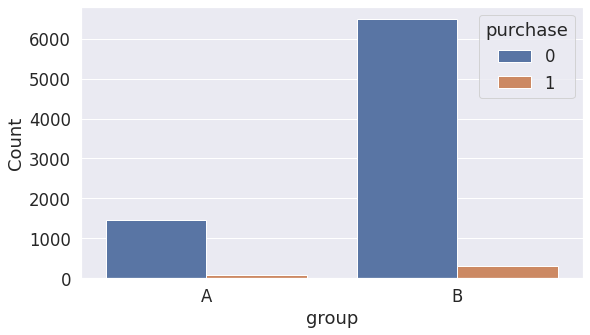

In [19]:
ax = sns.countplot(x = 'grp', hue = 'purchase',
            data = users)
plt.xlabel("group");
plt.ylabel("Count");

In [20]:
# пользователи, совершмвшие покупку
pay_users = users.query('purchase == 1')

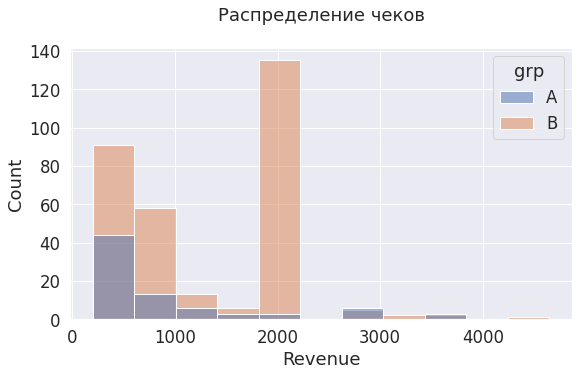

In [21]:
ax = sns.histplot(data = pay_users, x = 'rev', hue = 'grp')
ax.set_title('Распределение чеков\n');
ax.set_xlabel('Revenue');

В тестовой группе видим резкий всплеск покупок на 1900 р. Изменение только механики оплаты вряд ли могло к этому привести. Возможно была в это же время запущена маркетинговая акция, стимулирующая продажи именно по этой цене. Это ставит вопрос о корректности проведения всего эксперимента.

In [22]:
metrics = users.groupby('grp', as_index = False)\
                    .agg({'student_id': 'count', 'purchase': 'sum','rev': 'sum','purchase': 'sum' })\
                    .rename(columns = {'student_id': 'num_users', 'purchase': 'num_pay_users'})\
                    .assign(ARPU = lambda x:round((x.rev / x.num_users),2), \
                            ARPPU = lambda x: round((x.rev / x.num_pay_users),2),\
                            CR = lambda x: round((x.num_pay_users / x.num_users) * 100,2))
metrics

,grp,num_users,num_pay_users,rev,ARPU,ARPPU,CR
0,A,1535,78,72820.0000,47.44,933.59,5.08
1,B,6793,313,393074.0035,57.86,1255.83,4.61


Главной метрикой считаю конверсию в покупку, т.к. изменение механики оплаты скорее всего направлено на улучшение процесса покупки, таким образом увеличивая ее вероятность.
\
Посмотрев на показатель конверсии, видим, что наблюдается снижение показателя в тестовой группе. Проведем статистическую оценку. Конверсия является категориальной величиной (т.к. пользователь либо совершил оплату (1), либо нет (0)), также как и принадлежность к группе А или В. Поэтому для проверки гипотезы выбираю тест хи-квадрат.

In [23]:
metrics.CR

0    5.08
1    4.61
Name: CR, dtype: float64

 Гипотезы:
- Н0 - нет связи между конверсией и группой пользователя.
- Н1-связь есть, конверсия зависит от того, к какой группе принадлежит пользователь.

Создадим таблицу сопряженности для проведения теста:

In [24]:
stat = users.groupby(['purchase', 'grp'], as_index = False)\
                .agg({'student_id': 'count'})\
                .pivot(index = 'purchase', columns = 'grp', values = 'student_id').T
stat

purchase,0,1
grp,,
A,1457,78
B,6480,313


In [25]:
print('p-value =', scipy.stats.chi2_contingency(stat, correction = False)[1])

p-value = 0.4280822964525912


p-value > 0,05, поэтому нет оснований отклонить нулевую гипотезу об отсутствии связи между конверсией и группой пользователя.

Выводы:

- Главной метрикой была выбрана конверсия в покупку, которая уменьшилась в тестовой группе. Проведенный статистический анализ получившихся результатов эксперимента показал, что различие в конверсии между группами не является статистически значимым.
- Учитывая подозрительно частую оплату на 1900 в тестовой группе, а также дисбаланс в размере групп, рекомендовано обратить внимание на корректость проведения эксперимента. 
- После уточнения данных о правильности проведения эксперимента и корректности сплитования, если чеки на 1900 оказались случайны и не были вызваны какой-либо маркетинговой активностью, возможно провести статистический анализ метрики ARPU.
- При иимеющихся данных не рекомендовано запускать новую механику оплаты на всех пользователей.

## Задание 2. SQL

2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

2.1.2 Задача

Дана таблица default.peas

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [26]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database': 'default',
                      'user': 'student', 
                      'password': 'dpo_python_2020'
                     }

In [27]:
q1 = '''
SELECT st_id, toDateTime(timest) as timest, correct, subject FROM default.peas
'''

In [28]:
default_peas = ph.read_clickhouse(query = q1, connection = connection_default)

In [29]:
default_peas.head()

,st_id,timest,correct,subject
0,100379,2021-10-30 13:32:29,1,Theory of probability
1,100379,2021-10-30 14:11:19,0,Vizualization
2,100379,2021-10-30 15:54:22,1,Theory of probability
3,100379,2021-10-30 16:44:50,1,Vizualization
4,100379,2021-10-30 17:15:05,1,Theory of probability


In [30]:
q2 = '''
SELECT
  count(st_id) as num_students
FROM
  (
    SELECT
      st_id,
      sum(correct)
    FROM
      default.peas
    group by
      st_id
    having
      sum(correct) >= 20
  ) 
'''
num_students = ph.read_clickhouse(query = q2, connection = connection_default)

In [31]:
num_students

,num_students
0,136


2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Дана таблицы: default.peas (см. выше), default.studs и default.final_project_check

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

    ARPU 
    ARPAU 
    CR в покупку 
    СR активного пользователя в покупку 
    CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

Все данные находятся в табличном виде в Clickhouse

In [32]:
q3 = '''
SELECT st_id, toDateTime(timest) as timest, correct, subject FROM default.peas
'''

In [33]:
default_peas_1 = ph.read_clickhouse(query = q3, connection = connection_default)

In [34]:
default_peas_1.head()

,st_id,timest,correct,subject
0,100379,2021-10-30 13:32:29,1,Theory of probability
1,100379,2021-10-30 14:11:19,0,Vizualization
2,100379,2021-10-30 15:54:22,1,Theory of probability
3,100379,2021-10-30 16:44:50,1,Vizualization
4,100379,2021-10-30 17:15:05,1,Theory of probability


In [35]:
q4 = '''
SELECT * FROM default.studs
'''

In [36]:
default_studs = ph.read_clickhouse(query = q4, connection = connection_default)

In [37]:
default_studs.head()

,st_id,test_grp
0,100379,pilot
1,101432,control
2,104818,pilot
3,104885,pilot
4,104966,pilot


In [38]:
q5 = '''
SELECT st_id, toDateTime(sale_time) as saletime, money, subject FROM default.final_project_check
'''

In [39]:
default_final_project_check = ph.read_clickhouse(query = q5, connection = connection_default)

In [40]:
default_final_project_check.head()

,st_id,saletime,money,subject
0,101432,2021-10-31 04:44:32,85000,Math
1,101432,2021-10-31 12:43:50,65000,Vizualization
2,104885,2021-10-30 17:05:55,65000,Vizualization
3,104885,2021-10-30 22:49:33,75000,Statistics
4,106464,2021-10-31 13:17:13,85000,Math


In [41]:
q6 = '''
WITH t_users AS (SELECT studs.st_id as users, studs.test_grp, sum(check.money) as money FROM studs 
                 LEFT JOIN (SELECT st_id, sum(money) AS money FROM final_project_check GROUP BY st_id) AS check
                 ON studs.st_id=check.st_id GROUP BY st_id,test_grp),
    t_active AS (SELECT st_id, sum(correct) num_task FROM peas GROUP BY st_id HAVING sum(correct)>10),
    t_math AS   (SELECT st_id, math_money, math_task FROM (SELECT st_id, sum(correct) math_task FROM peas 
                 WHERE subject='Math' GROUP BY st_id HAVING sum(correct) >=2) AS act_math
                 LEFT JOIN (SELECT st_id, money as math_money FROM final_project_check WHERE subject='Math') as math_buy 
                 ON act_math.st_id=math_buy.st_id)

SELECT
  test_grp,
  ROUND(avg(money), 2) AS ARPU,
  ROUND(
    sumIf(money, num_task > 0) / countIf(num_task > 0),
    2
  ) AS ARPAU,
  ROUND(countIf(money > 0) / count(users) * 100, 2) AS CR,
  ROUND(
    countIf(
      money > 0
      and num_task > 10
    ) / countIf(num_task > 0) * 100,
    2
  ) AS CR_A,
  ROUND(
    countIf(math_money > 0) / countIf(math_task >= 2) * 100,
    2
  ) AS CR_math
FROM
  t_users FULL
  JOIN t_active ON t_users.users = t_active.st_id FULL
  JOIN t_math ON t_users.users = t_math.st_id
GROUP BY
  test_grp
    '''
metrics = ph.read_clickhouse(query = q6, connection = connection_default)

In [42]:
metrics

,test_grp,ARPU,ARPAU,CR,CR_A,CR_math
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


## Задание 3. Python

3.1 Задача

1) Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
\
2) Реализуйте функцию, которая будет строить графики по получаемым метрикам.

### Первая функция

In [43]:
def metrics_update(groups, group_add, active_studs, checks):
    group_add = pd.read_csv(r'Проект_2_group_add.csv', sep = ',')
    
    group_add.rename(columns = {group_add.columns[0]: 'student_id'}, inplace = True)
    groups.rename(columns = {groups.columns[0]: 'student_id'}, inplace = True)
    # Соберем один датафрейм
    groups = groups.append(group_add, ignore_index = True)
    
    users = active_studs.merge(groups, on = 'student_id', how = 'left')\
                             .query('grp == grp')\
                             .merge(checks,on = 'student_id', how = 'left')\
                             .fillna({'rev': 0})
    users['purchase'] = users.rev.apply(lambda x: 1 if x != 0 else 0)
    
    metrics = users.groupby('grp', as_index = False)\
                    .agg({'student_id': 'count', 'purchase': 'sum', 'rev': 'sum', 'purchase': 'sum' })\
                    .rename(columns = {'student_id': 'num_users', 'purchase': 'num_pay_users'})\
                    .assign(ARPU = lambda x:round((x.rev / x.num_users), 2), \
                            ARPPU = lambda x: round((x.rev / x.num_pay_users), 2), \
                            CR = lambda x: round((x.num_pay_users / x.num_users) * 100, 2))
    return(metrics)

In [44]:
new_metrics = metrics_update(groups, group_add, active_studs, checks)
new_metrics 

,grp,num_users,num_pay_users,rev,ARPU,ARPPU,CR
0,A,1538,78,72820.0000,47.35,933.59,5.07
1,B,6803,314,394974.0035,58.06,1257.88,4.62


### Вторая функция

In [45]:
def draw_plots(df_metrics):
    
    sns.set_theme(style = "whitegrid")
    fig, axs = plt.subplots(ncols = 3, figsize = (20, 6))
    
    sns.barplot(x = "grp", y = "CR", data = new_metrics, ax = axs[0]).set_title('CR')
    sns.barplot(x = "grp", y = "ARPU", data = new_metrics, ax = axs[1]).set_title('ARPU')
    sns.barplot(x = "grp", y = "ARPPU", data = new_metrics, ax = axs[2]).set_title('ARPPU')

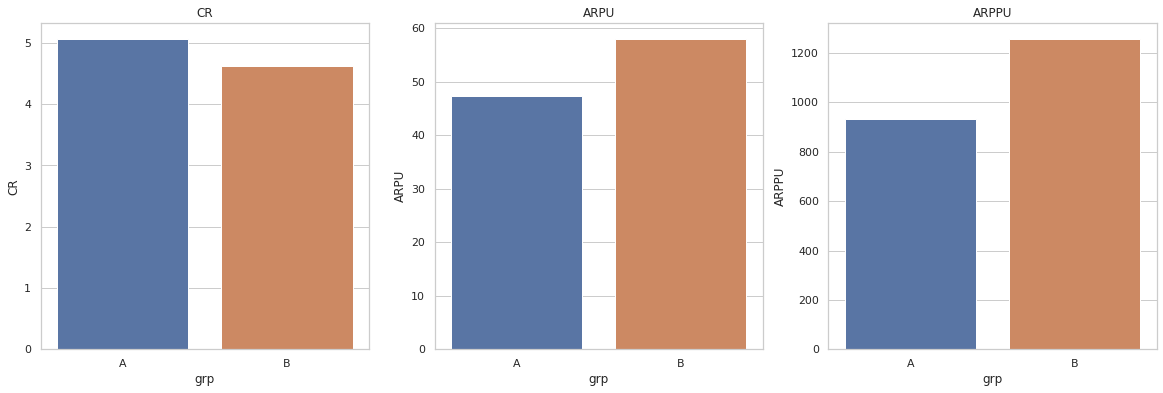

In [46]:
draw_plots(new_metrics)